In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from deficit_defs import *

Splikes version  0.1.2
Plasticnet version  0.1.6
macOS-10.16-x86_64-i386-64bit
Base Image File: asdf/bbsk081604_all_log2dog.asdf


In [4]:
_debug = False
if _debug:
    print("Debugging")

In [5]:
base='sims/2022-11-03'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

In [6]:
rf_size=19
#eta_mat=linspace(1e-7,5e-6,11)
eta=2e-6
blur_mat=linspace(0,8,17)
print(blur_mat)
number_of_neurons=20
number_of_processes=4

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8. ]


In [7]:
base_image_file='asdf/bbsk081604_all.asdf'
print("Base Image File:",base_image_file)

blur=2.5
Lfname=pi5.filtered_images(
                            base_image_file,
                            {'type':'blur','size':blur},
                            {'type':'log2dog','sd1':1,'sd2':3},
                            )
Rfname=pi5.filtered_images(
                            base_image_file,
                            {'type':'log2dog','sd1':1,'sd2':3},
                            )




Base Image File: asdf/bbsk081604_all.asdf
Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.

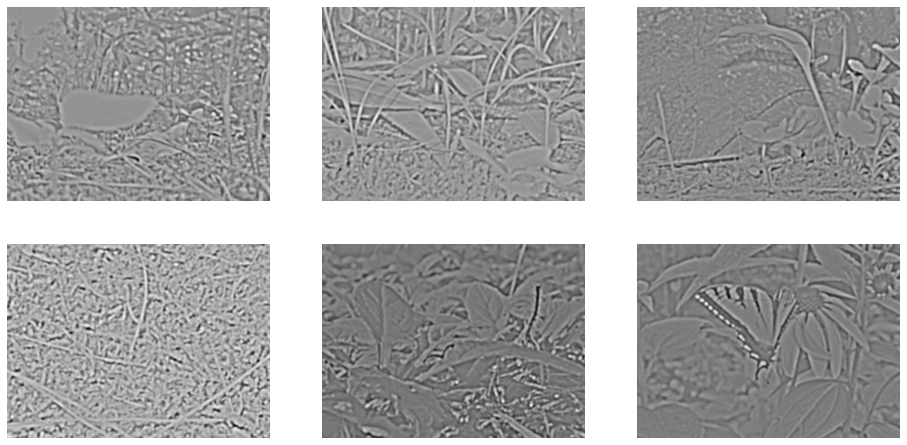

In [8]:
image_data=pi5.asdf_load_images(Lfname)
im=[arr.astype(float)*image_data['im_scale_shift'][0]+
        image_data['im_scale_shift'][1] for arr in image_data['im']]

del image_data
plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(im[i],cmap=plt.cm.gray)
    plt.axis('off')

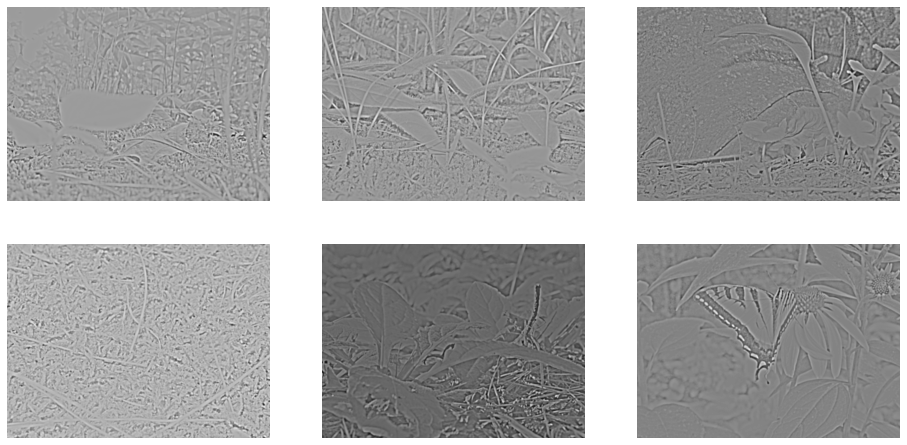

In [9]:
image_data=pi5.asdf_load_images(Rfname)
im=[arr.astype(float)*image_data['im_scale_shift'][0]+
        image_data['im_scale_shift'][1] for arr in image_data['im']]

del image_data
plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(im[i],cmap=plt.cm.gray)
    plt.axis('off')

## Premake the image files

In [10]:
blur_mat=linspace(0,8,17)

In [11]:
base_image_file='asdf/bbsk081604_all.asdf'
print("Base Image File:",base_image_file)

normal_image=pi5.filtered_images(
                                base_image_file,
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )

for blur in blur_mat:

    Lfname=pi5.filtered_images(
                                base_image_file,
                                {'type':'blur','size':blur},
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )




Base Image File: asdf/bbsk081604_all.asdf
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_fcf524b121311f6c8d3021738d0d9176.asdf from cache.Using cache_images/cache_images_84de1df7ec28e9fff71aa008fabc28ab.asdf from cache.Using cache_images/cache_images_9a3a8257f75df7fd8fd5b6731003da35.asdf from cache.Using cache_images/cache_images_dc449597e25b03aa549e59deb9230231.asdf from cache.Using cache_images/cache_images_a5a33890731b1a868baaebecee76c71d.asdf from cache.Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_6aedbf5e39e78c1beb4a47361965a2da.asdf from cache.Using cache_images/cache_images_9cead8acc8be7d3720d5d49758a4beba.asdf from cache.Using cache_images/cache_images_61ad4395acceb1fc40934928f3dcc141.asdf from cache.Using cache_images/cache_images_f1b88d5f120a7046b8e62e430edf90ad.asdf from cache.Using cache_images/cache_images_43c7077591f67b05006774599a6b41da.as

In [12]:
def blur_deficit(blur=[2.5,-1],
            noise=[0.1,.1],
                 rf_size=19,eta=2e-6,
           number_of_neurons=10,
           total_time=8*day,
           save_interval=1*hour):

    
    if _debug:
        total_time=1*minute
        save_interval=1*second
        
    images=[]
    
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'log2dog','sd1':1,'sd2':3},
                                    )
        images.append(im)
        
    pre1=pn.neurons.natural_images(images[0],
                                   rf_size=rf_size,verbose=False)

    pre2=pn.neurons.natural_images(images[1],rf_size=rf_size,
                                other_channel=pre1,
                                verbose=False)

    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]

In [13]:
def run_one_left_blur(params,overwrite=False):
    import plasticnet as pn
    count,eta,noise,blur,number_of_neurons,sfname=(params.count,params.eta,params.noise,params.blur,
                                        params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()

    t=16*day
    ts=1*hour

    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=blur_deficit(blur=[blur,-1],total_time=t,
                 noise=noise,eta=eta,number_of_neurons=number_of_neurons,
               save_interval=ts)

    
    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname
    


In [14]:
total_time=8*day
real_time=5*60+ 55

In [15]:
from collections import namedtuple
params = namedtuple('params', ['count', 'eta','noise','blur','number_of_neurons','sfname'])
all_params=[]
count=0
eta_count=0
eta=2e-6
noise_count=0
open_eye_noise=0.0

for blur_count,blur in enumerate(blur_mat):
    all_params.append(params(count=count,
                     eta=eta,
                         blur=blur,
                     noise=open_eye_noise,
                     number_of_neurons=number_of_neurons,
         sfname=f'{base}/deficit %d neurons logdog %d eta %d noise %d blur.asdf' % 
                                         (number_of_neurons,eta_count,noise_count,blur_count)))
        
for a in all_params[:10]:
    print(a)

print(len(all_params))

print(time2str(real_time*len(all_params)/number_of_processes))


params(count=0, eta=2e-06, noise=0.0, blur=0.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 0 blur.asdf')
params(count=0, eta=2e-06, noise=0.0, blur=0.5, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 1 blur.asdf')
params(count=0, eta=2e-06, noise=0.0, blur=1.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 2 blur.asdf')
params(count=0, eta=2e-06, noise=0.0, blur=1.5, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 3 blur.asdf')
params(count=0, eta=2e-06, noise=0.0, blur=2.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 4 blur.asdf')
params(count=0, eta=2e-06, noise=0.0, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 5 blur.asdf')
params(count=0, eta=2e-06, noise=0.0, blur=3.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons

In [17]:
do_params=make_do_params(all_params)
len(do_params)

1

In [18]:
%%time
run_one_left_blur(all_params[0],overwrite=True)

Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[.] Sequence Time Elapsed...5 m, 27.06 s
CPU times: user 5min 26s, sys: 3.22 s, total: 5min 29s
Wall time: 5min 30s


'sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 0 blur.asdf'

In [28]:
pool = Pool(processes=number_of_processes)
result = pool.map_async(run_one_left_blur, all_params)
print(result.get())

Using cache_images/cache_images_84de1df7ec28e9fff71aa008fabc28ab.asdf from cache.Using cache_images/cache_images_a5a33890731b1a868baaebecee76c71d.asdf from cache.Using cache_images/cache_images_6aedbf5e39e78c1beb4a47361965a2da.asdf from cache.Using cache_images/cache_images_9a3a8257f75df7fd8fd5b6731003da35.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[[[[.] Sequence Time Elapsed...5 m, 37.83 s
.] Sequence Time Elapsed...5 m, 38.63 s
.] Sequence Time Elapsed...5 m, 38.78 s
.] Sequence Time Elapsed...5 m, 39.90 s
Using cache_images/cache_images_dc449597e25b03aa549e59deb9230231.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[Using cache_images/cache_

In [ ]:
RR={}
count=0
for params in all_params:
    RR[params.sfname]=Results(params.sfname)

In [ ]:
count=0
for blur_count,blur in enumerate(blur_mat):
    params=all_params[count]
    count+=1
    R=RR[params.sfname]
    blur=params.blur
    μ1,μ2=R.μσ[0][0]
    σ1,σ2=R.μσ[1][0]

    s+=blur,μ1,μ2,σ1,σ2

blur,μ1,μ2,σ1,σ2=s.arrays()
figure()
errorbar(blur,μ1,yerr=2*σ1,marker='o',elinewidth=1,label='Deprived',color=cm.Oranges(0.3))
errorbar(blur,μ2,yerr=2*σ2,marker='s',elinewidth=1,label='Normal',color=cm.Blues(0.3))
xlabel('Blur Size [pixels]')
ylabel('Maximum Response')
text(0,38.5,r'($2\sigma$ errorbars)',fontsize=12)
